In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/content/raw_data_islamabad_20241224-20251224.csv")

In [4]:
df.head()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,timestamp,temperature_2m,relative_humidity_2m,surface_pressure,wind_speed_10m,wind_direction_10m,precipitation,cloud_cover,city,latitude,longitude
0,108.3,107.1,941.0,73.9,17.6,14.0,2024-12-24 00:00:00,7.7,80,953.9,6.4,333,0.0,0,Islamabad,33.6996,73.0362
1,98.3,97.1,754.0,58.8,15.7,27.0,2024-12-24 01:00:00,7.9,78,953.3,8.8,321,0.0,0,Islamabad,33.6996,73.0362
2,92.4,91.3,618.0,45.4,14.3,38.0,2024-12-24 02:00:00,7.7,78,953.1,8.1,315,0.0,0,Islamabad,33.6996,73.0362
3,87.5,86.6,514.0,33.2,13.6,46.0,2024-12-24 03:00:00,7.4,77,952.8,7.9,321,0.0,0,Islamabad,33.6996,73.0362
4,83.1,82.2,461.0,22.8,13.4,52.0,2024-12-24 04:00:00,7.2,77,952.3,7.3,330,0.0,0,Islamabad,33.6996,73.0362


# **Defining the aqi_breakpoints dictionary**

In [5]:
import numpy as np

# 1. Define the aqi_breakpoints dictionary
# Note: Carbon monoxide (CO) breakpoints are converted from mg/m³ to µg/m³
# 1 mg/m³ = 1000 µg/m³
aqi_breakpoints = {
    'pm2_5': [
        (0, 30, 0, 50),
        (31, 60, 51, 100),
        (61, 90, 101, 200),
        (91, 120, 201, 300),
        (121, 250, 301, 400),
        (251, 500, 401, 500)
    ],
    'pm10': [
        (0, 50, 0, 50),
        (51, 100, 51, 100),
        (101, 250, 101, 200),
        (251, 350, 201, 300),
        (351, 430, 301, 400),
        (431, 1000, 401, 500)
    ],
    'ozone': [
        (0, 50, 0, 50),
        (51, 100, 51, 100),
        (101, 168, 101, 200),
        (169, 208, 201, 300),
        (209, 748, 301, 400),
        (749, 1000, 401, 500) # Assuming an upper limit for calculation beyond 748
    ],
    'carbon_monoxide': [
        (0, 1000, 0, 50),     # 1 mg/m³ = 1000 µg/m³, so 1 mg/m³ breakpoint becomes 1000 µg/m³
        (1001, 2000, 51, 100),   # 2 mg/m³ = 2000 µg/m³
        (2001, 10000, 101, 200),  # 10 mg/m³ = 10000 µg/m³
        (10001, 17000, 201, 300), # 17 mg/m³ = 17000 µg/m³
        (17001, 34000, 301, 400), # 34 mg/m³ = 34000 µg/m³
        (34001, 50000, 401, 500)  # Assuming an upper limit for calculation beyond 34 mg/m³
    ],
    'sulphur_dioxide': [
        (0, 40, 0, 50),
        (41, 80, 51, 100),
        (81, 380, 101, 200),
        (381, 800, 201, 300),
        (801, 1600, 301, 400),
        (1601, 2500, 401, 500) # Assuming an upper limit for calculation beyond 1600
    ],
    'nitrogen_dioxide': [
        (0, 40, 0, 50),
        (41, 80, 51, 100),
        (81, 180, 101, 200),
        (181, 280, 201, 300),
        (281, 400, 301, 400),
        (401, 600, 401, 500) # Assuming an upper limit for calculation beyond 400
    ]
}


# **Defining Funtion to calculate AQI**

In [6]:
def calculate_aqi_for_pollutant(concentration, pollutant_name):
    # 3. Handle NaN concentrations
    if np.isnan(concentration):
        return None

    # 4. Retrieve breakpoints for the pollutant
    if pollutant_name not in aqi_breakpoints:
        raise ValueError(f"No AQI breakpoints found for pollutant: {pollutant_name}")

    breakpoints = aqi_breakpoints[pollutant_name]

    # 6. Handle cases where the concentration is below the lowest breakpoint
    if concentration <= breakpoints[0][1]: # C_high of the first interval
        return 0

    # Iterate through breakpoints to find the correct interval
    for i_low, i_high, bp_low, bp_high in breakpoints:
        if i_low <= concentration <= i_high:
            # 5. Implement linear interpolation
            aqi = ((bp_high - bp_low) / (i_high - i_low)) * (concentration - i_low) + bp_low
            # 7. Ensure that the calculated AQI is rounded to the nearest integer
            return int(round(aqi))

    # 8. For concentrations exceeding the highest defined breakpoint
    # If concentration is greater than the highest breakpoint in the list
    # use the last interval's slope and cap the AQI at 500.
    last_interval = breakpoints[-1]
    i_low_last, i_high_last, bp_low_last, bp_high_last = last_interval

    # Calculate AQI using the slope of the last interval
    # The formula remains the same, but the concentration is outside the defined range
    # We'll calculate it and then cap it.
    aqi = ((bp_high_last - bp_low_last) / (i_high_last - i_low_last)) * (concentration - i_low_last) + bp_low_last

    return int(round(min(aqi, 500))) # Cap AQI at 500

# **Calculating AQI**

In [7]:
pollutant_columns = ['pm2_5', 'pm10', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone']

for pollutant in pollutant_columns:
    df[f'{pollutant}_aqi'] = df[pollutant].apply(lambda x: calculate_aqi_for_pollutant(x, pollutant))



In [8]:
aqi_columns = [f'{p}_aqi' for p in pollutant_columns]
df['overall_aqi'] = df[aqi_columns].max(axis=1)

print("Overall AQI calculated and added to the DataFrame.")
df.head()

Overall AQI calculated and added to the DataFrame.


,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,timestamp,temperature_2m,relative_humidity_2m,surface_pressure,...,city,latitude,longitude,pm2_5_aqi,pm10_aqi,carbon_monoxide_aqi,nitrogen_dioxide_aqi,sulphur_dioxide_aqi,ozone_aqi,overall_aqi
0,108.3,107.1,941.0,73.9,17.6,14.0,2024-12-24 00:00:00,7.7,80,953.9,...,Islamabad,33.6996,73.0362,256,106,0,92,0,0,256
1,98.3,97.1,754.0,58.8,15.7,27.0,2024-12-24 01:00:00,7.9,78,953.3,...,Islamabad,33.6996,73.0362,222,98,0,73,0,0,222
2,92.4,91.3,618.0,45.4,14.3,38.0,2024-12-24 02:00:00,7.7,78,953.1,...,Islamabad,33.6996,73.0362,202,92,0,57,0,0,202
3,87.5,86.6,514.0,33.2,13.6,46.0,2024-12-24 03:00:00,7.4,77,952.8,...,Islamabad,33.6996,73.0362,188,88,0,0,0,0,188
4,83.1,82.2,461.0,22.8,13.4,52.0,2024-12-24 04:00:00,7.2,77,952.3,...,Islamabad,33.6996,73.0362,173,83,0,0,0,52,173


# **Plotting Overall AQI over Time**

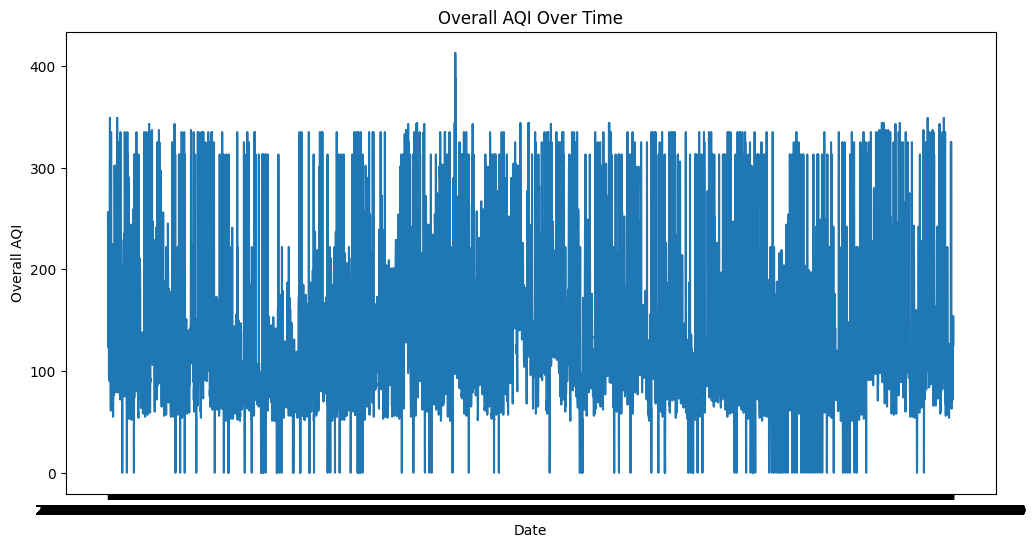

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['overall_aqi'])
plt.title('Overall AQI Over Time')
plt.xlabel('Date')
plt.ylabel('Overall AQI')
plt.show()

# **Distribution of Overall AQI**

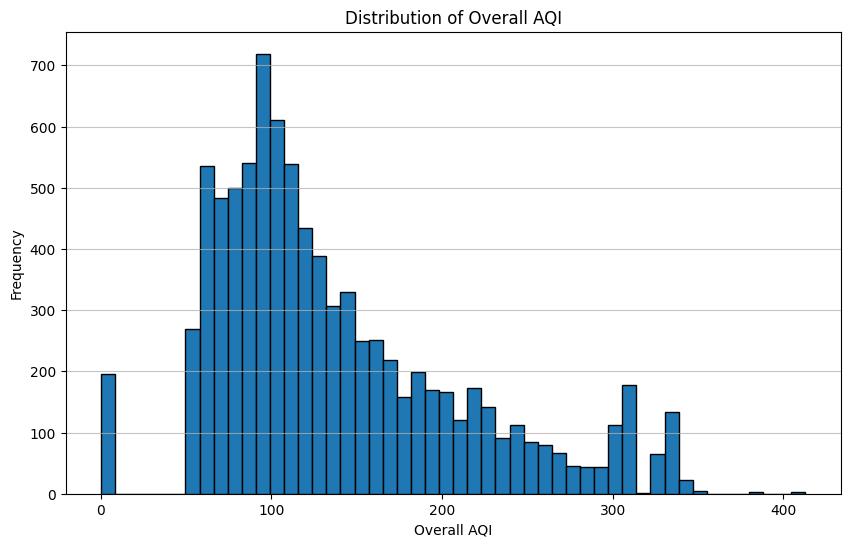

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df['overall_aqi'], bins=50, edgecolor='black')
plt.title('Distribution of Overall AQI')
plt.xlabel('Overall AQI')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek # Monday=0, Sunday=6
df['month'] = df['timestamp'].dt.month

print("Extracted 'hour_of_day', 'day_of_week', and 'month' from the timestamp column.")
display(df[['timestamp', 'hour_of_day', 'day_of_week', 'month']].head())

Extracted 'hour_of_day', 'day_of_week', and 'month' from the timestamp column.


,timestamp,hour_of_day,day_of_week,month
0,2024-12-24 00:00:00,0,1,12
1,2024-12-24 01:00:00,1,1,12
2,2024-12-24 02:00:00,2,1,12
3,2024-12-24 03:00:00,3,1,12
4,2024-12-24 04:00:00,4,1,12


# **Ploting AQI by Hour of Day**


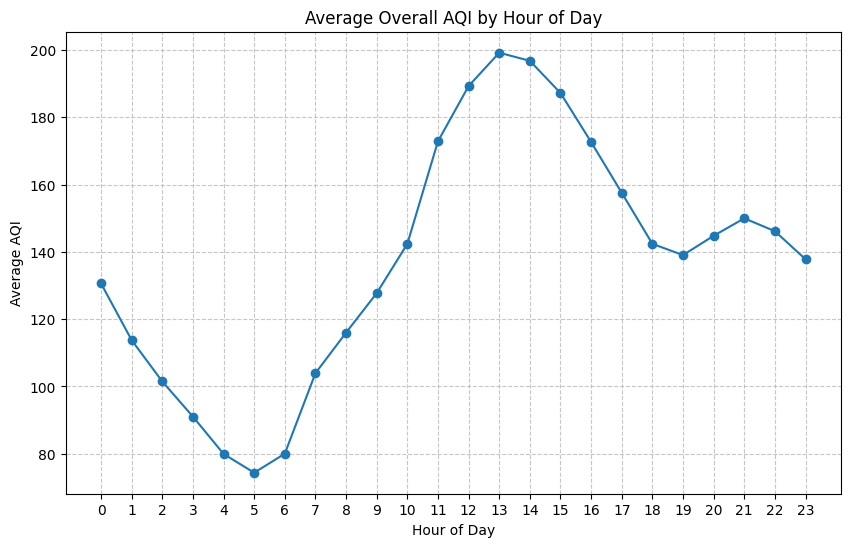

In [13]:
avg_aqi_by_hour = df.groupby('hour_of_day')['overall_aqi'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(avg_aqi_by_hour['hour_of_day'], avg_aqi_by_hour['overall_aqi'], marker='o')
plt.title('Average Overall AQI by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average AQI')
plt.xticks(range(0, 24)) # Ensure all hours are displayed on the x-axis
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# **Ploting AQI by Day of Week**

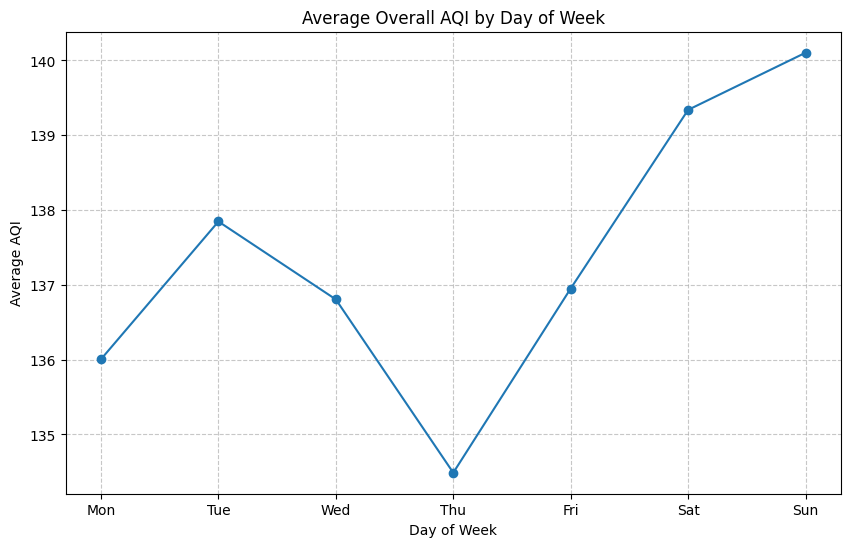

In [14]:
avg_aqi_by_day = df.groupby('day_of_week')['overall_aqi'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(avg_aqi_by_day['day_of_week'], avg_aqi_by_day['overall_aqi'], marker='o')
plt.title('Average Overall AQI by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average AQI')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) # Label x-axis with days of the week
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# **Ploting AQI by Month**

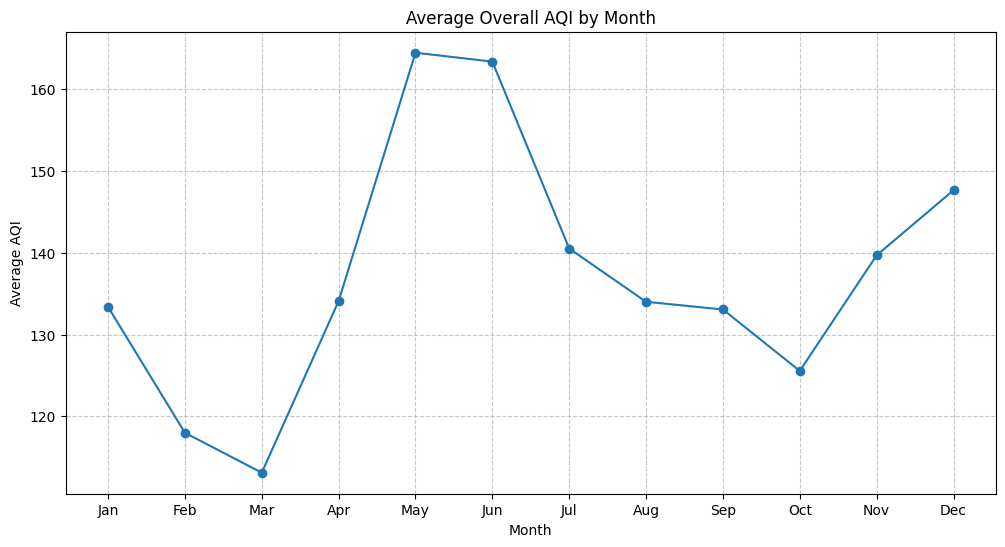

In [15]:
avg_aqi_by_month = df.groupby('month')['overall_aqi'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(avg_aqi_by_month['month'], avg_aqi_by_month['overall_aqi'], marker='o')
plt.title('Average Overall AQI by Month')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # Label x-axis with month names
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()